<a href="https://colab.research.google.com/github/tnusser/ImageRetrieval/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [40]:
import tensorflow as tf
import numpy as np
import sklearn
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Conv2DTranspose, Reshape
from keras.models import Model, Sequential
import keras.backend as K 
import matplotlib.pyplot as plt

## 3.1 Dataset Preparation

In [2]:
 (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [97]:
x_train = (raw_x_train/255).astype("float32")
x_test = (raw_x_test/255).astype("float32")

## 3.2 Building the Autoencoder

In [98]:
x_val = x_train[:10000]
x_train = x_train[10000:150000]

In [93]:
i = Input(shape=(32, 32, 3))
e1 = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
e2 = MaxPooling2D(pool_size=(3, 3))(e1)
e3 = Conv2D(64, (3, 3), activation="relu")(e2)
e4 = MaxPooling2D(pool_size=(3, 3))(e3)
e5 = Flatten()(e4)
e6 = Dense(10, activation='relu')(e5)

encoder = Model(i, e6, name='encoder')
encoder.summary()

conv_shape = K.int_shape(e1)
d_i = Input(shape=(10,))
d1 = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu',)(d_i)
d2 = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(d1)
d3 = Conv2DTranspose(filters=16, kernel_size=3, activation="relu", padding="same")(d2)
d4 = BatchNormalization()(d3)
d5 = Conv2DTranspose(filters=3, kernel_size=3, activation="sigmoid", padding="same")(d4)

decoder = Model(d_i, d5, name='decoder')
decoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 10)                2570

In [94]:
autoencoder_outputs = decoder(encoder(i))
autoencoder = Model(i, autoencoder_outputs, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              (None, 10)                21962     
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         365571    
Total params: 387,533
Trainable params: 387,501
Non-trainable params: 32
_________________________________________________________________


In [101]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = autoencoder.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=1, batch_size=1024)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 114s 3ms/step - loss: 0.0330 - accuracy: 0.5678 - val_loss: 0.0560 - val_accuracy: 0.5443
Epoch 2/3
40000/40000 [==============================] - 117s 3ms/step - loss: 0.0304 - accuracy: 0.5825 - val_loss: 0.0544 - val_accuracy: 0.5523
Epoch 3/3
40000/40000 [==============================] - 114s 3ms/step - loss: 0.0300 - accuracy: 0.5846 - val_loss: 0.0521 - val_accuracy: 0.5656


In [103]:
print(history.history)

{'val_loss': [0.056010592728853226, 0.05437951844334602, 0.05213676424026489], 'val_accuracy': [0.5443210005760193, 0.5523285269737244, 0.5655810832977295], 'loss': [0.032980407989025115, 0.030429144033789636, 0.029966319340467455], 'accuracy': [0.56783724, 0.5824903, 0.58463347]}


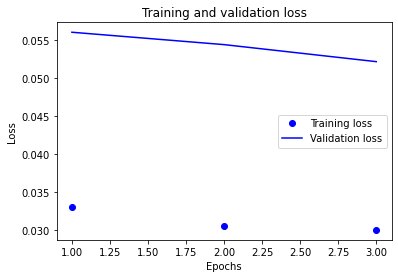

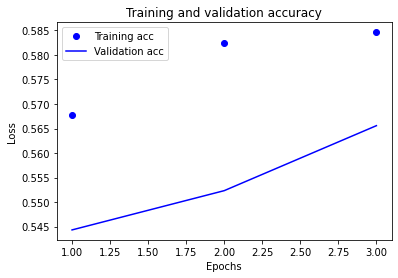

In [105]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()